# Transfer learning with Tensorflow Part 3: Scaling up(Food Vision Mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of training data(levaraging the power of deep-learning).

Original food 101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/

and our baseline to beat is 50.76% accuracy across 101 classes

In [1]:
import tensorflow as tf
import sys
tf.config.list_physical_devices('GPU')

2025-08-30 17:45:19.562790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756572319.580257   19183 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756572319.585885   19183 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756572319.598571   19183 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756572319.598590   19183 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756572319.598592   19183 computation_placer.cc:177] computation placer alr

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Creating helper functions
In previous notebooks, we've created a series of helper functions to do different tasks let's download them


In [2]:
# !wget https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py

In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir


## 101 Food Classes: working with less data
Our goal is to beat the original food 101 paper with 10% of training data, so let's download it

The data we're downloading comes from the original food 101 dataset but has been preprocessed using the image_data_modification notebook: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [4]:
import os

if not os.path.exists('101_food_classes_10_percent.zip'): 
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
    unzip_data('101_food_classes_10_percent.zip')
    
train_dir= "101_food_classes_10_percent/train/"
test_dir= "101_food_classes_10_percent/test/"

In [5]:
# How many images / classes are there?

walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/foie_gras'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/club_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheese_plate'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/garlic_bread'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/gnocchi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/samosa'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/donuts'.
There are 0 directories and 250 images in '101_food_class

In [6]:
# Setup data inputs
import tensorflow as tf

IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.


I0000 00:00:1756572342.019611   19183 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13500 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:09:00.0, compute capability: 8.9


Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes.

Here are the steps we're going to take:

* Create a model ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless(no top layers) Functional EfficientNetB0 backboned-model
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of test data, to save epoch time)

In [7]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percet_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [8]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers, preprocessing, Sequential

# Setup data augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2)], name="data_augmentation")
    # layers.Rescaling(1/255.) rescale inputs of images between 0 & 1 requiried by some models

In [9]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3),name="input_layer")

x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen do
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names),activation="softmax",name="output_layer")(x)
model = tf.keras.Model(inputs,outputs)

In [10]:
# Get summary of model created
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool_layer           │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [11]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(len(test_data) * 0.15),
                                           callbacks=[checkpoint_callback])


Epoch 1/5


I0000 00:00:1756572358.156390   19292 cuda_dnn.cc:529] Loaded cuDNN version 91100


237/237 ━━━━━━━━━━━━━━━━━━━━ 77s 266ms/step - accuracy: 0.1702 - loss: 3.9277 - val_accuracy: 0.4457 - val_loss: 2.5525
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.4824 - loss: 2.3305 - val_accuracy: 0.5040 - val_loss: 2.0774
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.5413 - loss: 1.9245 - val_accuracy: 0.5254 - val_loss: 1.9298
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.5872 - loss: 1.7150 - val_accuracy: 0.5257 - val_loss: 1.8612
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.6157 - loss: 1.5452 - val_accuracy: 0.5421 - val_loss: 1.7892


In [12]:
# Evaluate on whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 62s 79ms/step - accuracy: 0.5604 - loss: 1.6895


[1.5850244760513306, 0.584673285484314]

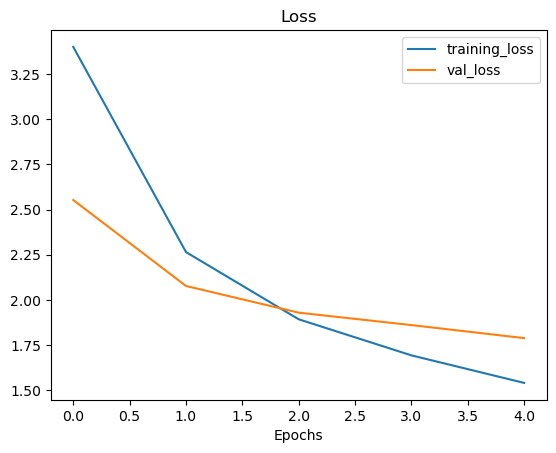

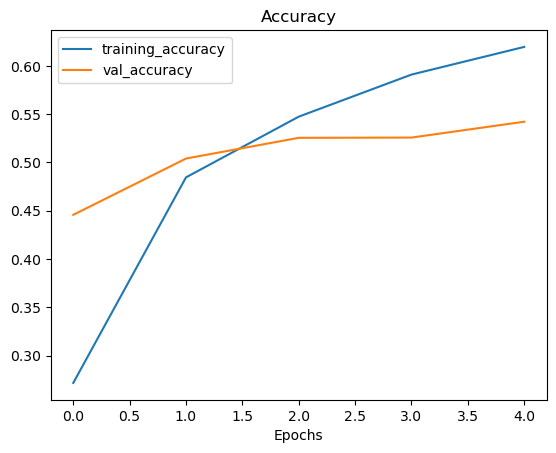

In [13]:
plot_loss_curves(history_all_classes_10_percent)

**Question** What do these curves suggests - overfitting - performing too well and not able to generalise to new data

## Fine-tuning

In [14]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# refreeze every layer except the last 5 layers
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [15]:
# recompile model with lower learning rate typically best practice
base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy",
                   metrics=["accuracy"])

In [16]:
# What layers in model are trainable
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [17]:
# Check which layers are trainable in base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [18]:
fine_tune_epochs = 10 # model has already done 5 epochs (feature extraction), this is the total number of epochs we're after 
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(len(test_data) * 0.15),
                                           callbacks=[checkpoint_callback],
                                           initial_epoch = history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.6448 - loss: 1.4314 - val_accuracy: 0.5474 - val_loss: 1.7506
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.6680 - loss: 1.3274 - val_accuracy: 0.5490 - val_loss: 1.7303
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.6906 - loss: 1.2319 - val_accuracy: 0.5620 - val_loss: 1.6909
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.7024 - loss: 1.1639 - val_accuracy: 0.5588 - val_loss: 1.7062
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.7179 - loss: 1.1104 - val_accuracy: 0.5479 - val_loss: 1.7371
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.7302 - loss: 1.0658 - val_accuracy: 0.5463 - val_loss: 1.7028


In [19]:
# evaluate on whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.5740 - loss: 1.6012


[1.4956989288330078, 0.5979406237602234]

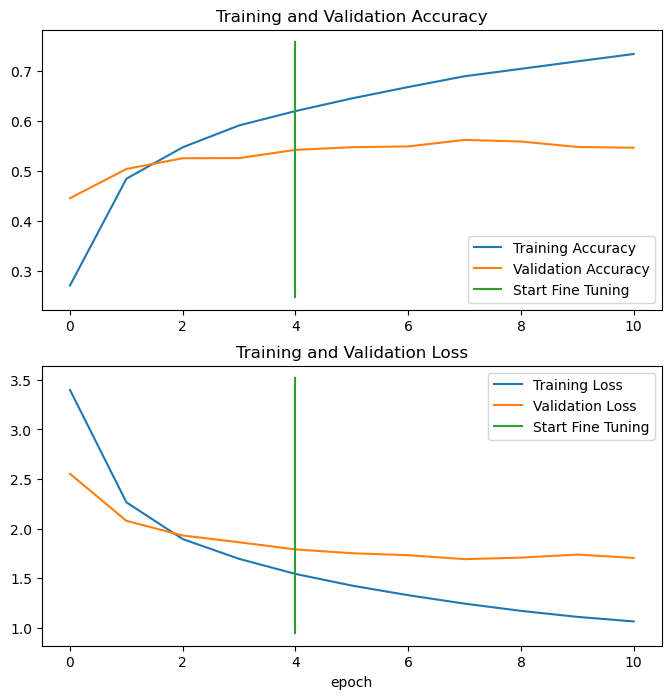

In [20]:
# compare the histories of feature extraction model with fine tuned model
compare_historys(original_history=history_all_classes_10_percent, new_history=history_all_classes_10_percent_fine_tune)

## Saving and loading our model

To use our model in an external application we'll need to save it / export it somewhere

In [21]:
# Save our model
model.save('./Models/101_food_classes_10_percent_big_model.keras')

In [22]:
# Load an evaluate saved model
from tensorflow.keras.models import load_model
loaded_model = tf.keras.models.load_model('./Models/101_food_classes_10_percent_big_model.keras')

/usr/lib/python3.13/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/lib/python3.13/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [23]:
# Evaluate loaded model and compare with pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.5740 - loss: 1.6012


[1.4956989288330078, 0.5979406237602234]

In [24]:
# results should be very similar to our saved model
all_classes_10_percent_fine_tune_results

[1.4956989288330078, 0.5979406237602234]

## Evaluating the performance of big model across all different classes

Let's make some predictions, visualize them then later find out which predictions were the most wrong

## Making predictions with out mode

In [25]:
# Make predictions with model
preds_probs = model.predict(test_data,verbose=1) # set verbose parameter to see how long's left

790/790 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step


In [26]:
# How many predictions are there
len(preds_probs)

25250

In [27]:
# What's the shape of our predictions
preds_probs.shape

(25250, 101)

In [28]:
# Let's see what first ten preds look like
preds_probs[:10]

array([[9.5443770e-02, 6.1555021e-04, 2.1170349e-01, ..., 9.3026494e-05,
        1.0150671e-02, 8.7784743e-03],
       [9.5686263e-01, 1.6196807e-07, 5.2019599e-04, ..., 8.7112025e-04,
        1.0565544e-06, 4.6892569e-06],
       [3.1139389e-01, 9.9078184e-03, 2.9263936e-02, ..., 6.3572102e-04,
        1.1896363e-03, 2.2627406e-03],
       ...,
       [1.9311897e-01, 1.1966684e-05, 3.2889294e-03, ..., 2.2765499e-02,
        1.7596692e-03, 2.9645380e-04],
       [1.3122846e-01, 4.5469328e-04, 3.1537268e-01, ..., 7.4244017e-04,
        7.7969214e-04, 1.9964523e-04],
       [4.3070805e-01, 7.6853821e-06, 2.2485121e-03, ..., 2.5923098e-03,
        2.3127934e-05, 9.6132507e-04]], shape=(10, 101), dtype=float32)

In [29]:
# What does the first probability array look like?
preds_probs[0],len(preds_probs[0]), sum(preds_probs[0])

(array([9.54437703e-02, 6.15550205e-04, 2.11703494e-01, 9.15653800e-07,
        2.87040493e-05, 1.96325655e-05, 2.88868585e-04, 2.57781339e-05,
        1.80190131e-02, 1.15062937e-03, 1.10964002e-05, 2.59224526e-05,
        1.02677452e-03, 8.64996400e-06, 1.35150235e-02, 2.18436401e-03,
        1.12213827e-04, 2.29730946e-03, 7.10567553e-03, 2.35057123e-05,
        1.46717974e-03, 7.70217011e-05, 5.85079426e-04, 2.69608834e-04,
        6.75909047e-04, 5.18564740e-03, 1.72641745e-03, 6.64526669e-05,
        3.70734707e-02, 1.15033204e-03, 2.40622594e-05, 1.08799711e-03,
        1.00860966e-03, 4.66855863e-06, 6.09925725e-02, 6.13625671e-05,
        1.35512382e-03, 2.36865366e-03, 6.24780133e-02, 1.28919317e-04,
        4.29649721e-04, 6.61480380e-03, 3.96987394e-04, 4.86240242e-05,
        6.84975705e-04, 3.12645971e-05, 3.50763393e-03, 3.07531853e-04,
        4.20538481e-06, 4.35709730e-02, 6.66417938e-04, 1.06061314e-04,
        6.05027936e-02, 2.25416999e-02, 3.77081669e-05, 3.648077

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to prediction method

In [30]:
# We get one prediction probability per class (in our case there's 101 prediction probabilites)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability for sample 0 looks like: {preds_probs[0]}")
print(f"The class with the highest predicted probability by model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability for sample 0 looks like: [9.54437703e-02 6.15550205e-04 2.11703494e-01 9.15653800e-07
 2.87040493e-05 1.96325655e-05 2.88868585e-04 2.57781339e-05
 1.80190131e-02 1.15062937e-03 1.10964002e-05 2.59224526e-05
 1.02677452e-03 8.64996400e-06 1.35150235e-02 2.18436401e-03
 1.12213827e-04 2.29730946e-03 7.10567553e-03 2.35057123e-05
 1.46717974e-03 7.70217011e-05 5.85079426e-04 2.69608834e-04
 6.75909047e-04 5.18564740e-03 1.72641745e-03 6.64526669e-05
 3.70734707e-02 1.15033204e-03 2.40622594e-05 1.08799711e-03
 1.00860966e-03 4.66855863e-06 6.09925725e-02 6.13625671e-05
 1.35512382e-03 2.36865366e-03 6.24780133e-02 1.28919317e-04
 4.29649721e-04 6.61480380e-03 3.96987394e-04 4.86240242e-05
 6.84975705e-04 3.12645971e-05 3.50763393e-03 3.07531853e-04
 4.20538481e-06 4.35709730e-02 6.66417938e-04 1.06061314e-04
 6.05027936e-02 2.25416999e-02 3.77081669e-05 3.64807732e-02
 1.09581389e-01 4.56015300e-03 1.9631678

In [31]:
test_data.class_names[2]

'baklava'

In [32]:
# Get pred classes of each label
pred_classes = preds_probs.argmax(axis=1)
pred_classes[:10]

array([ 2,  0,  0, 38,  8, 78, 29,  0,  2,  0])

In [33]:
# How many pred classes do we have
len(pred_classes)

25250

In [34]:
pred_classes = preds_probs.argmax(axis=1)
pred_classes

array([  2,   0,   0, ...,  56,  94, 100], shape=(25250,))

Now we've got a predictions array of all our model's predictions, to evaluate them, we need to compare them to the original test dataset labels

In [35]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []

test_data

for images,labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0,0,0,1,......0] we want the index value where the one occurs 101 total classes
y_labels[:10]

2025-08-30 17:51:18.175136: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0)]

In [36]:
# how many y labels
len(y_labels)

25250

## Evaluating our model's predictions

One way to check that our model' predictions arraay is in the same order as our test labels array is to find the accuracy score

In [37]:
loaded_model_results

[1.4956989288330078, 0.5979406237602234]

In [38]:
# Let's try scikit learn's accuracy score function and see what it comes up with!
import sklearn
sk_learn_acc = sklearn.metrics.accuracy_score(y_labels,pred_classes)
sk_learn_acc

0.5979405940594059

In [39]:
# Does this metric come close to our model's evaluate results
import numpy as np

np.isclose(loaded_model_results[1],sk_learn_acc)

np.True_

## Let's get visual: making a confusing matrix

In [40]:
from helper_functions import make_confusion_matrix

In [41]:
# Get a list of class names
class_names = test_data.class_names

In [42]:
# We need to make some changes to our make confusion matrix function to ensure x_labels print vertically
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()
  ## Changed(plot x_labels vertically)
  plt.xticks(rotation=70,fontsize=text_size)
  plt.yticks(fontsize=text_size)
  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


In [43]:
make_confusion_matrix(y_true=y_labels, 
                      y_pred = pred_classes, 
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20,
                      savefig=True)

## Let's keep the evaluation train going, time for a classification report

scikit learn has a helpful function for acquiring many different classification metric per class (e.g precision, recall, and F1) called classification report let's try it out

In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.36      0.18      0.24       250
           1       0.56      0.71      0.63       250
           2       0.61      0.61      0.61       250
           3       0.83      0.55      0.66       250
           4       0.53      0.42      0.47       250
           5       0.48      0.39      0.43       250
           6       0.70      0.78      0.73       250
           7       0.86      0.66      0.75       250
           8       0.25      0.59      0.35       250
           9       0.44      0.63      0.52       250
          10       0.50      0.42      0.46       250
          11       0.78      0.57      0.66       250
          12       0.67      0.63      0.65       250
          13       0.57      0.50      0.54       250
          14       0.53      0.58      0.56       250
          15       0.46      0.31      0.37       250
          16       0.72      0.52      0.60       250
          17       0.39    

The numbers above give a great class by class evaluation of our model's predictions but with so many classes it can be quite hard to understand.

How about we create a visualization to get better understanding?

In [45]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.35772357723577236,
  'recall': 0.176,
  'f1-score': 0.2359249329758713,
  'support': 250.0},
 '1': {'precision': 0.5619047619047619,
  'recall': 0.708,
  'f1-score': 0.6265486725663717,
  'support': 250.0},
 '2': {'precision': 0.612,
  'recall': 0.612,
  'f1-score': 0.612,
  'support': 250.0},
 '3': {'precision': 0.8253012048192772,
  'recall': 0.548,
  'f1-score': 0.6586538461538461,
  'support': 250.0},
 '4': {'precision': 0.5276381909547738,
  'recall': 0.42,
  'f1-score': 0.46770601336302897,
  'support': 250.0},
 '5': {'precision': 0.47572815533980584,
  'recall': 0.392,
  'f1-score': 0.4298245614035088,
  'support': 250.0},
 '6': {'precision': 0.697841726618705,
  'recall': 0.776,
  'f1-score': 0.7348484848484849,
  'support': 250.0},
 '7': {'precision': 0.8645833333333334,
  'recall': 0.664,
  'f1-score': 0.751131221719457,
  'support': 250.0},
 '8': {'precision': 0.24873096446700507,
  'recall': 0.588,
  'f1-score': 0.34958382877526756,
  'support': 250.0}

Let's plot all of our classes F1 scores....

In [46]:
# Create empty dictionary 
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
    if k == "accuracy": # stop once we get to accuracy key
        break
    else: 
        # Add class names and F1 scores to new dict
        class_f1_scores[class_names[int(k)]] = v['f1-score']
class_f1_scores

{'apple_pie': 0.2359249329758713,
 'baby_back_ribs': 0.6265486725663717,
 'baklava': 0.612,
 'beef_carpaccio': 0.6586538461538461,
 'beef_tartare': 0.46770601336302897,
 'beet_salad': 0.4298245614035088,
 'beignets': 0.7348484848484849,
 'bibimbap': 0.751131221719457,
 'bread_pudding': 0.34958382877526756,
 'breakfast_burrito': 0.5154975530179445,
 'bruschetta': 0.45751633986928103,
 'caesar_salad': 0.6605080831408776,
 'cannoli': 0.650103519668737,
 'caprese_salad': 0.535031847133758,
 'carrot_cake': 0.5561904761904762,
 'ceviche': 0.36930455635491605,
 'cheese_plate': 0.6032482598607889,
 'cheesecake': 0.38966202783300197,
 'chicken_curry': 0.45741324921135645,
 'chicken_quesadilla': 0.6597077244258872,
 'chicken_wings': 0.7334669338677354,
 'chocolate_cake': 0.5335570469798657,
 'chocolate_mousse': 0.38391224862888484,
 'churros': 0.7325581395348837,
 'clam_chowder': 0.7203219315895373,
 'club_sandwich': 0.6858316221765913,
 'crab_cakes': 0.40618101545253865,
 'creme_brulee': 0.7475

In [47]:
# Turn F1 scores in data frame for visualization
import pandas as pd 
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score",ascending=False)

In [48]:
f1_scores[:10]

class_names  f1-score
33            edamame  0.968000
63           macarons  0.871795
86            sashimi  0.839844
54  hot_and_sour_soup  0.839458
69            oysters  0.831373
75                pho  0.824859
32          dumplings  0.820116
65            mussels  0.817996
51          guacamole  0.804388
68        onion_rings  0.803245

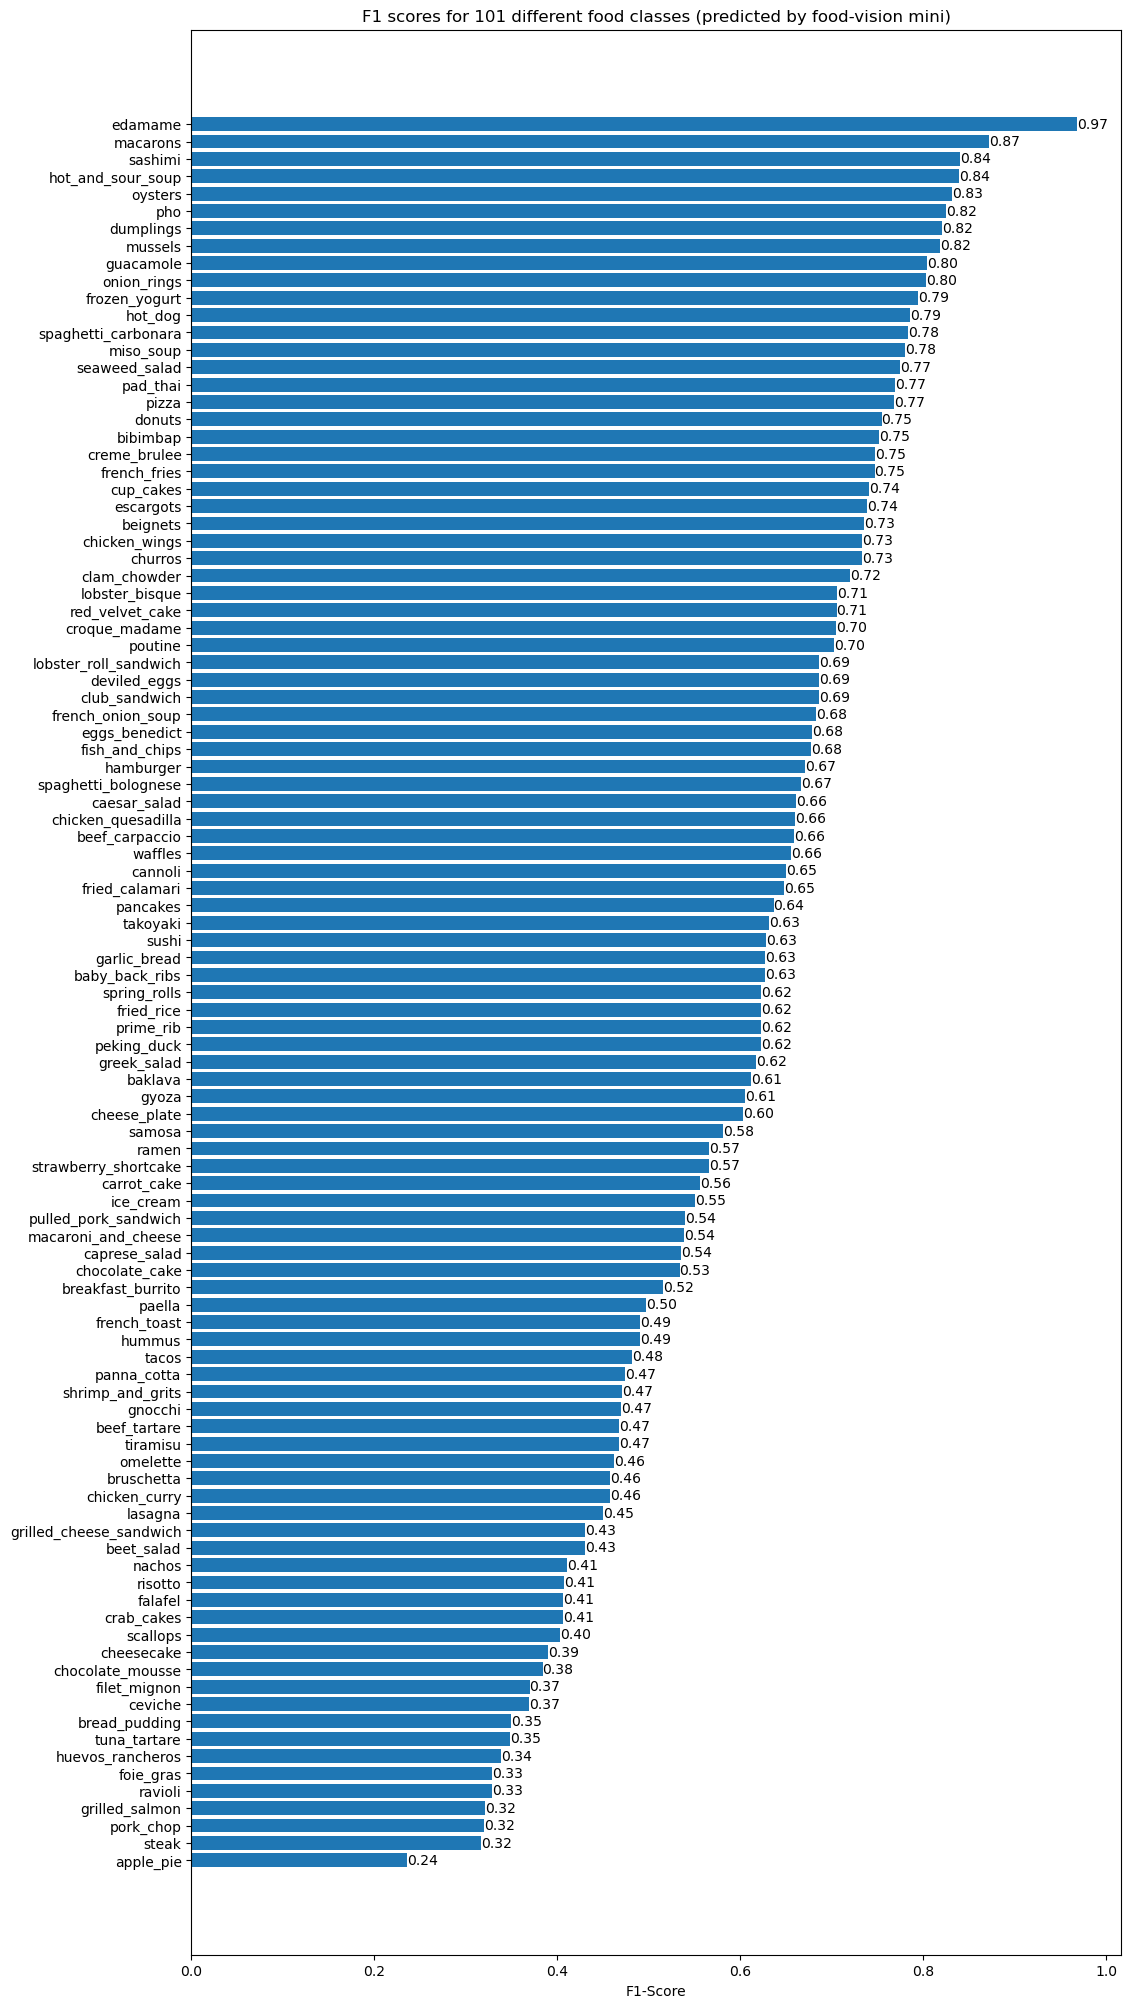

In [49]:
fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"]);
ax.set_xlabel("F1-Score")
ax.set_title("F1 scores for 101 different food classes (predicted by food-vision mini)")
ax.invert_yaxis()
# challenge add values of end of each bar with the actual f1 score

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for rect in rects:
        width = rect.get_width()
        y = rect.get_y() + rect.get_height()/2
        x = width  
        ax.text(x, y, f'{width:.2f}', ha=ha[xpos], va='center')


autolabel(scores, "right")


Exercise: Try visualizing some of the most poorly predicted classes, notice any trends?  Why might we have trouble with them?

## Visualizing predictions on custom images
Now this is the real test how does the model go on food images not on our test dataset(images of our own)

To visualize our model's predictions on our own images, we'll need a function to loadd and preprocess images, specifically it'll need to:
* Read in a target image filepath using tf.io.read_file()
* Turn the image into a Tensor using tf.io.decode_image
* Resize the image tensor to be the same size as input data using tf.image.resize()
* Scale the image to get all the pixel values between 0 and 1(if necessary some models have rescaling built in

In [64]:
# Create a function to load and prepare images
def load_and_prep_image(file_name, img_shape=224, scale=True):
    """ 
    Reads in an image from filename, turns it into a tensor and reshapes into a specified shape (img_shape, img_shape, color_channels=3).

    Args:
        filename(str): path to target image
        image_shape (int): height / width dimension of target image size
        scale(bool): scale pixel values from 0-255 to 0-1 or not

    Returns:
        Image tensor of shape(img_shape, img_shape,3)
    """
    # Read in the image
    img = tf.io.read_file(file_name)

    # Decode image
    img =  tf.io.decode_image(img,channels=3)

    # rezie image
    img = tf.image.resize(img, [img_shape,img_shape])
    
    # Scale yes / no
    if(scale):
        return img / 255. # don't need to rescale images for EfficientNet models in tensorflow
    else:
        return img

Now we've got a function to load and prepare target images, let's now write some code to visualized images, their target label, and our model's predictions

Specifically we'll write code to:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image(s) along with the mode'ls predictions, perediction probability and truth label

101_food_classes_10_percent/test/mussels/3336932.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[2.43592542e-04 2.99198204e-04 2.30039307e-03 8.58482417e-06
  3.02508997e-05 1.16965290e-04 1.35594804e-04 1.87536971e-05
  4.88385500e-04 4.99441847e-03 7.84039366e-06 2.07928685e-03
  3.60293058e-03 5.47478069e-03 9.80182900e-04 1.54794790e-02
  2.32998584e-03 2.59305252e-05 8.21523718e-04 4.23420242e-05
  3.14914435e-03 2.59677693e-03 2.47807940e-03 5.17356070e-03
  8.28299765e-03 2.53628998e-04 1.32122263e-03 1.81189782e-04
  2.09050668e-05 9.28451028e-03 5.53334576e-06 9.30872804e-04
  4.43047196e-01 7.79734459e-03 2.48354801e-04 1.55980391e-02
  9.38751269e-03 2.43726536e-03 1.17129268e-04 1.92275343e-06
  1.57996314e-04 2.72774545e-04 6.77369069e-04 3.87259014e-03
  1.45884673e-03 8.67682465e-05 1.00047584e-03 7.86198187e-04
  4.63220320e-04 2.31978670e-03 7.71853200e-04 5.95394243e-03
  7.58354459e-03 2.28024600e-03 1.03158969e-03 1.80717558e-03
  6.44674947e-06 2.59597432e-02 7.4990937

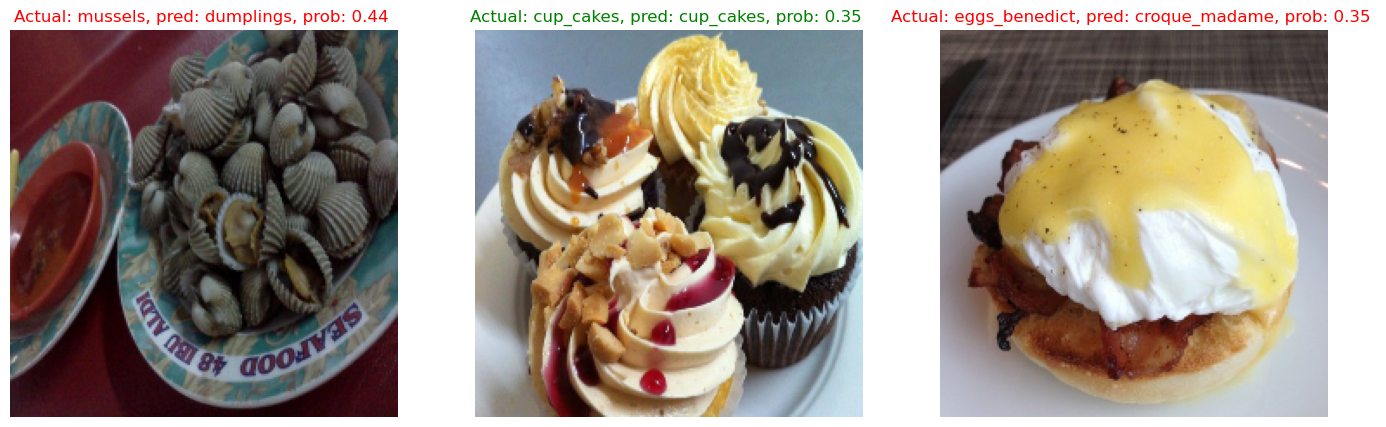

In [59]:
# Make preds on a series of random images
import os
import random
plt.figure(figsize=(17,10))

for i in range(3):
    # Choose random images from random classes
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + '/' + class_name))
    filepath = test_dir + class_name + "/" + filename
    print(filepath)
    # Load image and make preds
    img = load_and_prep_image(filepath, scale=False)
    # print('Original ', img.shape)
    img_expanded=tf.expand_dims(img,axis=0)
    # print('EXPANDED ', img_expanded.shape)
    pred_prob = model.predict(img_expanded) # Get pred probabilities array
    pred_class = class_names[pred_prob.argmax()] # Get highest prediction and match to class name list
    print(pred_prob)
    print(pred_class)
    # Plot the images
    plt.subplot(1,3,i+1)
    plt.imshow(img/255.)
    if class_name == pred_class: # if predicted class matches make text green
        title_color = 'g'
    else:
        title_color = 'r'
    plt.title(f"Actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f} ",c=title_color)
    plt.axis(False)

In [57]:
import random
random.choice(class_names)

'strawberry_shortcake'

## Find the most wrong predictions
To find out where our model is most wrong, let's write some code to find out the following:
1. Get all of the image file paths in the test dataset using the list_files method
2. Create a Pandas DataFrame of the image filepaths, ground truth labels, predicted classes(from our model), max prediction probabilities, prediction class names, ground truth class_names.
3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top).
5. Visualize the images with the highest prediction probabilities but have the wrong prediction

In [112]:
# Get all image file_paths in test data set
filepaths=[]
test_dir
for filepath in test_data.list_files(test_dir + '*/*.jpg',shuffle=False):
    filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [113]:
# create a data frame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths, 
                        "y_true":y_labels,
                        "y_pred":pred_classes,
                        "pred_condf":preds_probs.max(axis=1), # get the max confidence
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]
                       })
pred_df

img_path  y_true  y_pred  \
0      b'101_food_classes_10_percent/test/apple_pie/1...       0      85   
1      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3      b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
4      b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
...                                                  ...     ...     ...   
25245  b'101_food_classes_10_percent/test/waffles/942...     100     100   
25246  b'101_food_classes_10_percent/test/waffles/954...     100     100   
25247  b'101_food_classes_10_percent/test/waffles/961...     100      17   
25248  b'101_food_classes_10_percent/test/waffles/970...     100       8   
25249  b'101_food_classes_10_percent/test/waffles/971...     100     100   

       pred_condf y_true_classname y_pred_classname  
0        0.116268        apple_pie           samosa  
1        0.873258        apple_pie        apple_pie  
2        0.196695        apple_pie        apple_pie  
3        0.242396        apple_pie    bread_pudding  
4        0.729610        apple_pie    bread_pudding  
...           ...              ...              ...  
25245    0.930117          waffles          waffles  
25246    0.666870          waffles          waffles  
25247    0.209487          waffles       cheesecake  
25248    0.263499          waffles    bread_pudding  
25249    0.288048          waffles          waffles  

[25250 rows x 6 columns]

In [117]:
# Find out in our dataframe of which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      85   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_condf y_true_classname y_pred_classname  pred_correct  
0    0.116268        apple_pie           samosa         False  
1    0.873258        apple_pie        apple_pie          True  
2    0.196695        apple_pie        apple_pie          True  
3    0.242396        apple_pie    bread_pudding         False  
4    0.729610        apple_pie    bread_pudding         False

In [127]:
# Sort our df to have most wrong predictions at top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_condf",ascending=False)[:100]
top_100_wrong

img_path  y_true  y_pred  \
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
15359  b'101_food_classes_10_percent/test/lobster_rol...      61      53   
11024  b'101_food_classes_10_percent/test/fried_rice/...      44      70   
11642  b'101_food_classes_10_percent/test/garlic_brea...      46      10   
14691  b'101_food_classes_10_percent/test/ice_cream/3...      58      79   
...                                                  ...     ...     ...   
920    b'101_food_classes_10_percent/test/beef_carpac...       3      81   
25200  b'101_food_classes_10_percent/test/waffles/496...     100       8   
12393  b'101_food_classes_10_percent/test/grilled_che...      49      46   
15826  b'101_food_classes_10_percent/test/macarons/19...      63      29   
23740  b'101_food_classes_10_percent/test/strawberry_...      94       8   

       pred_condf         y_true_classname y_pred_classname  pred_correct  
23797    0.992734                    sushi          sashimi         False  
15359    0.988177    lobster_roll_sandwich        hamburger         False  
11024    0.987276               fried_rice         pad_thai         False  
11642    0.987004             garlic_bread       bruschetta         False  
14691    0.985979                ice_cream        prime_rib         False  
...           ...                      ...              ...           ...  
920      0.926999           beef_carpaccio            ramen         False  
25200    0.926717                  waffles    bread_pudding         False  
12393    0.926227  grilled_cheese_sandwich     garlic_bread         False  
15826    0.925544                 macarons        cup_cakes         False  
23740    0.925389     strawberry_shortcake    bread_pudding         False  

[100 rows x 7 columns]

Pandas(Index=18383, img_path=b'101_food_classes_10_percent/test/panna_cotta/2981284.jpg', y_true=73, y_pred=60, pred_condf=0.9562215209007263, y_true_classname='panna_cotta', y_pred_classname='lobster_bisque', pred_correct=False)

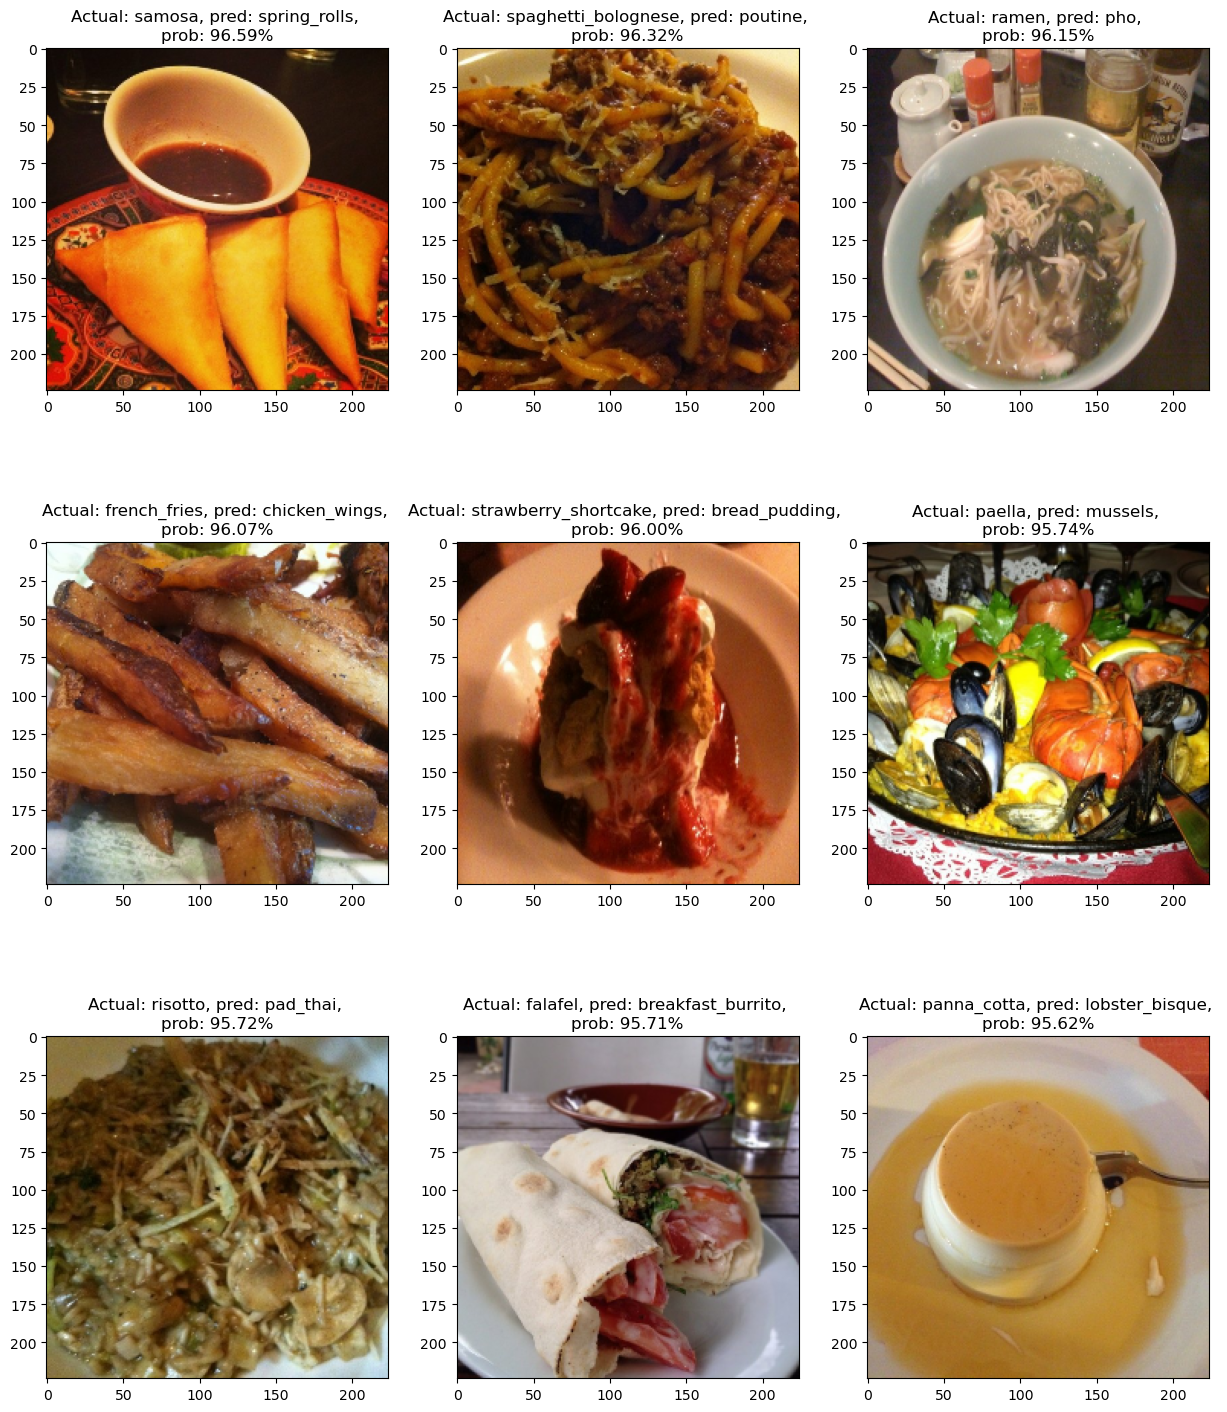

In [204]:
# 5. Visualize the test_data samples which have the wrong prediction but highest pred prob
top_9_wrong_images = pred_df[pred_df["pred_correct"] == False].sort_values("pred_condf",ascending=False)[:10]
top_9_wrong_images.values
images_to_view = 9 
start_index = 30
plt.figure(figsize=(15,10))

for i, row in enumerate(top_100_wrong[start_index: start_index + images_to_view].itertuples()):
    plt.subplot(3,3, i+1)
    plt.subplots_adjust(bottom=0.1, right=0.9, top=1.5)
    img = load_and_prep_image(row[1],scale=False)
    _,_,_,_,pred_prob,y_true_classname, y_pred_classname, _ = row # Only interested in few params of each row
    plt.imshow(img / 255.)
    plt.title(f"Actual: {y_true_classname}, pred: {y_pred_classname}, \nprob: {pred_prob:.2%}")
row